In [1]:
from sklearn.preprocessing import StandardScaler
#from factor_analyzer import FactorAnalyzer, calculate_kmo
from scipy.stats import bartlett
import pandas as pd
from sklearn.preprocessing import StandardScaler
#from factor_analyzer import FactorAnalyzer, calculate_kmo, calculate_bartlett_sphericity
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
#import pingouin as pg
import seaborn as sns
import requests

In [2]:
import pandas as pd
from transformers import CLIPProcessor, CLIPModel
import numpy as np
import requests
from PIL import Image
from io import BytesIO
import torch

In [3]:
data_path = "data_cleaned_feature_31.parquet"
data = pd.read_parquet(data_path)
print(data.columns)
data.shape

Index(['video_id', 'video_published_at', 'video_trending__date', 'channel_id',
       'video_title', 'video_description', 'video_default_thumbnail',
       'video_category_id', 'video_tags', 'video_duration', 'video_dimension',
       'video_definition', 'video_licensed_content', 'video_view_count',
       'video_like_count', 'video_comment_count', 'channel_title',
       'channel_description', 'channel_custom_url', 'channel_published_at',
       'channel_country', 'channel_view_count', 'channel_subscriber_count',
       'channel_have_hidden_subscribers', 'channel_video_count',
       'channel_localized_title', 'channel_localized_description',
       'engagement_rate', 'time_difference', 'video_duration_seconds'],
      dtype='object')


(23334, 30)

In [4]:
def time_to_seconds(time_str):
    days, time_part = time_str.split(" days ")
    days = int(days)
    h, m, s = map(int, time_part.split(":"))
    total_seconds = days * 86400 + h * 3600 + m * 60 + s
    return total_seconds

data['time_to_trend_difference_seconds'] = data['time_difference'].apply(time_to_seconds)
data['likes_per_view'] = data['video_like_count'] / data['video_view_count']
data['comments_per_view'] = data['video_comment_count'] / data['video_view_count']
data['is_weekend'] = pd.to_datetime(data['video_published_at']).dt.weekday >= 5

In [5]:
data['is_trending'] = data['time_difference'].apply(
    lambda x: 1 if int(x.split(" ")[0]) <= 1 else 0
)
data.is_trending.value_counts() ## checking how fast videos are trending

,count
is_trending,
1,16498
0,6836


In [6]:
# check negatives in time_to_trend difference_seconds
data[data['time_to_trend_difference_seconds'] < 0]

# check column video_trending__date and video_published_at and time_difference
data[['video_trending__date', 'video_published_at', 'time_difference']]

,video_trending__date,video_published_at,time_difference
0,2024-10-12,2024-10-11 00:00:06,0 days 23:59:54
1,2024-10-12,2024-10-11 11:07:25,0 days 12:52:35
2,2024-10-12,2024-10-09 12:30:27,2 days 11:29:33
3,2024-10-12,2024-10-12 02:03:10,-1 days +21:56:50
4,2024-10-12,2024-10-09 09:00:08,2 days 14:59:52
...,...,...,...
23329,2024-11-26,2024-11-25 11:00:32,0 days 12:59:28
23330,2024-11-26,2024-11-24 13:47:17,1 days 10:12:43
23331,2024-11-26,2024-11-25 12:00:06,0 days 11:59:54
23332,2024-11-26,2024-11-25 13:36:09,0 days 10:23:51


In [7]:
# do split (" ") and take the first element

data["time_difference_days"] = data["time_difference"].apply(lambda x: int(x.split(" ")[0]))
data["time_difference_days"]

,time_difference_days
0,0
1,0
2,2
3,-1
4,2
...,...
23329,0
23330,1
23331,0
23332,0


In [8]:
# use data['video_published_at'] to make a column if morning, afternoon, evening, night
data['video_published_at'] = pd.to_datetime(data['video_published_at'])
data['published_hour'] = data['video_published_at'].dt.hour
data['published_morning'] = data['published_hour'].between(6, 12)
data['published_afternoon'] = data['published_hour'].between(12, 18)
data['published_evening'] = data['published_hour'].between(18, 24)
data['published_night'] = data['published_hour'].between(0, 6)

In [9]:
data['channel_published_at'] = pd.to_datetime(data['channel_published_at'], errors='coerce').dt.tz_localize(None)
data['video_published_at'] = pd.to_datetime(data['video_published_at'], errors='coerce').dt.tz_localize(None)
data['channel_video_channel_publish_difference'] = (data['video_published_at'] - data['channel_published_at']).dt.days
data['channel_video_channel_publish_difference']
data['channel_video_channel_publish_difference'] = data['channel_video_channel_publish_difference'].fillna(data['channel_video_channel_publish_difference'].mean()) # di ko na alam kung tama to

In [10]:
data.shape

(23334, 42)

In [11]:
data['is_trending'].value_counts()

,count
is_trending,
1,16498
0,6836


In [12]:
data['is_weekend'].value_counts()

,count
is_weekend,
False,16493
True,6841


# doing image embeddings then pca to like 32/64

In [13]:
from torchvision import models, transforms
import torch
import pandas as pd
import numpy as np
import requests
from PIL import Image
from io import BytesIO
mobilenet = models.mobilenet_v2(pretrained=True)
mobilenet = mobilenet.eval()

preprocess = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2-b0353104.pth
100%|██████████| 13.6M/13.6M [00:00<00:00, 29.9MB/s]


In [17]:
from tqdm import tqdm

In [18]:
def get_mobilenet_embedding(url):
    try:
        response = requests.get(url, timeout=5)
        image = Image.open(BytesIO(response.content)).convert("RGB")
        image_tensor = preprocess(image).unsqueeze(0)
        with torch.no_grad():
            embeddings = mobilenet(image_tensor).squeeze().numpy()
        return embeddings
    except Exception as e:
        print(f"Failed to process {url}: {e}")
        return None

def generate_embeddings_with_mobilenet(data, thumbnail_column, embedding_dim=64):
    embeddings_list = []
    for url in tqdm(data[thumbnail_column], desc="Processing Thumbnails", unit="image"):
        embedding = get_mobilenet_embedding(url)
        if embedding is not None:
            embeddings_list.append(embedding)
        else:
            embeddings_list.append(np.zeros(1000))

    from sklearn.decomposition import PCA
    pca = PCA(n_components=embedding_dim)
    reduced_embeddings = pca.fit_transform(np.array(embeddings_list))

    embedding_columns = [f"mobilenet_embed_{i}" for i in range(embedding_dim)]
    embedding_df = pd.DataFrame(reduced_embeddings, columns=embedding_columns)

    updated_data = pd.concat([data.reset_index(drop=True), embedding_df], axis=1)
    return updated_data

data_with_embeddings = generate_embeddings_with_mobilenet(data, thumbnail_column='video_default_thumbnail')
data_with_embeddings.to_csv("data_with_mobilenet_embeddings.csv", index=False)

Processing Thumbnails: 100%|██████████| 23334/23334 [26:46<00:00, 14.53image/s]


In [21]:
data = data_with_embeddings.copy()

In [22]:
majority_class = data[data['is_trending'] == 1]
minority_class = data[data['is_trending'] == 0]
# shape
print(majority_class.shape, minority_class.shape)


(16498, 106) (6836, 106)


In [76]:
from sklearn.utils import resample


minority_upsampled = resample(minority_class,
                              replace=True,
                              n_samples=int(round(len(majority_class) * 0.5, -2)),
                              random_state=42)

data = pd.concat([majority_class, minority_upsampled])
data.is_trending.value_counts()

,count
is_trending,
1,16498
0,8200


In [77]:
columns_to_slice = [f"mobilenet_embed_{i}" for i in range(0, 64)]  # Adjust the range as needed
image_features = data_with_embeddings[columns_to_slice].columns.tolist()

In [78]:
categorical_features = [
    'video_category_id', 'is_weekend',
    'video_definition', 'video_dimension', 'video_licensed_content',
    'channel_country', 'channel_have_hidden_subscribers',
    'published_morning', 'published_afternoon', 'published_evening', 'published_night'
]
numerical_features = [
    'video_duration_seconds', 'channel_video_count', 'channel_video_channel_publish_difference'
]

In [79]:
X_categorical = data[categorical_features]
X_numerical = data[numerical_features]
X_image = data[image_features]
y = data['is_trending']

In [80]:
# from sklearn.ensemble import IsolationForest
# isolation_forest = IsolationForest(contamination=0.10, random_state=42)
# outliers = isolation_forest.fit_predict(X_numerical)

# data_cleaned = data[outliers != -1]
# data_cleaned.shape

In [81]:
import numpy as np
#X = np.hstack((X_numerical, X_categorical))
X = pd.concat((X_numerical, X_categorical, X_image),axis=1)
X.shape

(24698, 78)

In [82]:
from feature_engine.selection import DropConstantFeatures, DropDuplicateFeatures, DropCorrelatedFeatures
from feature_engine.pipeline import Pipeline

pipeline = Pipeline([
    ("drop_constant_features", DropConstantFeatures(tol=0.98)),
    ("drop_duplicate_features", DropDuplicateFeatures()),
    ("drop_correlated_features", DropCorrelatedFeatures(method='pearson', threshold=0.85))
])

X_final = pipeline.fit_transform(X)

In [83]:
# check difference of columns between X and X_final
removed = [i for i in set(X.columns) - set(X_final.columns)]
removed

['channel_have_hidden_subscribers', 'video_dimension', 'video_definition']

In [84]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_final, y, test_size=0.3, random_state=42)

In [85]:
final_categorical_features = [item for item in categorical_features if item not in removed]

In [86]:
X_train_categorical = X_train[final_categorical_features]
X_test_categorical = X_test[final_categorical_features]

X_train_numerical = X_train[numerical_features]
X_test_numerical = X_test[numerical_features]

X_train_image = X_train[image_features]
X_test_image = X_test[image_features]

In [87]:
from feature_engine.encoding import DecisionTreeEncoder
from feature_engine.encoding import OneHotEncoder
from feature_engine.encoding import MeanEncoder

encoder = DecisionTreeEncoder(random_state=42, regression=False)
X_train_encode = encoder.fit_transform(X_train_categorical, y_train)
X_test_encode = encoder.transform(X_test_categorical)

/usr/local/lib/python3.10/dist-packages/feature_engine/encoding/base_encoder.py:260: UserWarning: During the encoding, NaN values were introduced in the feature(s) channel_country.
  warnings.warn(


In [88]:
# from feature_engine.transformation import LogTransformer

# log_transformer = LogTransformer(variables=numerical_features)

# X_train_log = log_transformer.fit_transform(X_train_numerical)
# X_test_log = log_transformer.transform(X_test_numerical) # di naman gumana hahahaha

In [89]:
# from imblearn.combine import SMOTEENN
# smote_enn = SMOTEENN(random_state=42)
# X_train_resampled, y_train_resampled = smote_enn.fit_resample(X_train_combined, X_test_combined)

In [90]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_numerical)
X_test_scaled = scaler.transform(X_test_numerical)
# X_train_resampled, y_train_resampled = smote_enn.fit_resample(X_train_scaled, y_train)

In [91]:
X_train = np.hstack((X_train_encode, X_train_scaled, X_train_image))
X_test = np.hstack((X_test_encode, X_test_scaled, X_test_image))
X_train.shape, X_test.shape

((17288, 75), (7410, 75))

In [92]:
from sklearn.ensemble import RandomForestClassifier


model = RandomForestClassifier(max_depth=300,
        max_features='sqrt',
        n_estimators=1000,
        min_samples_leaf=1,
        min_samples_split=3,
        random_state=33)
model.fit(X_train, y_train)
accuracy = model.score(X_test, y_test)
print(f"Model Accuracy: {accuracy}")
from sklearn.metrics import classification_report, confusion_matrix
y_pred = model.predict(X_test)
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

Model Accuracy: 0.8564102564102564
[[1684  786]
 [ 278 4662]]
              precision    recall  f1-score   support

           0       0.86      0.68      0.76      2470
           1       0.86      0.94      0.90      4940

    accuracy                           0.86      7410
   macro avg       0.86      0.81      0.83      7410
weighted avg       0.86      0.86      0.85      7410



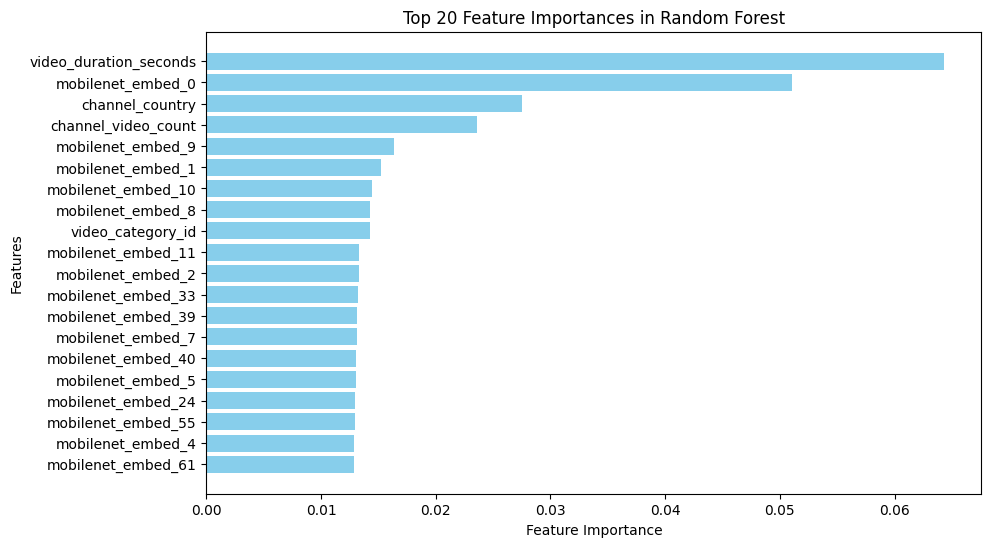

In [93]:
feature_names = pd.concat([data[final_categorical_features],data[numerical_features],data[image_features]]).columns
feature_importances = model.feature_importances_
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': feature_importances
}).sort_values(by='Importance', ascending=False)

top_features = importance_df.head(20)
plt.figure(figsize=(10, 6))
plt.barh(top_features['Feature'], top_features['Importance'], color='skyblue')
plt.xlabel('Feature Importance')
plt.ylabel('Features')
plt.title('Top 20 Feature Importances in Random Forest')
plt.gca().invert_yaxis()
plt.show()

In [94]:
importance_df['Prefix'] = importance_df['Feature'].str.extract(r'(mobilenet_embed)')

In [95]:
aggregated_importance = importance_df.groupby('Prefix')['Importance'].sum().reset_index()
aggregated_importance.columns = ['Feature Prefix', 'Total Importance']
aggregated_importance

,Feature Prefix,Total Importance
0,mobilenet_embed,0.849075


In [99]:

pd.concat([top_features, aggregated_importance], ignore_index=True)

,Feature,Importance,Feature Prefix,Total Importance
0,video_duration_seconds,0.064359,NaN,NaN
1,mobilenet_embed_0,0.051052,NaN,NaN
2,channel_country,0.027505,NaN,NaN
3,channel_video_count,0.023552,NaN,NaN
4,mobilenet_embed_9,0.016318,NaN,NaN
5,mobilenet_embed_1,0.015216,NaN,NaN
6,mobilenet_embed_10,0.014448,NaN,NaN
7,mobilenet_embed_8,0.014307,NaN,NaN
8,video_category_id,0.014300,NaN,NaN
9,mobilenet_embed_11,0.013301,NaN,NaN


In [96]:
combined_features = pd.concat([top_features, aggregated_importance], ignore_index=True)

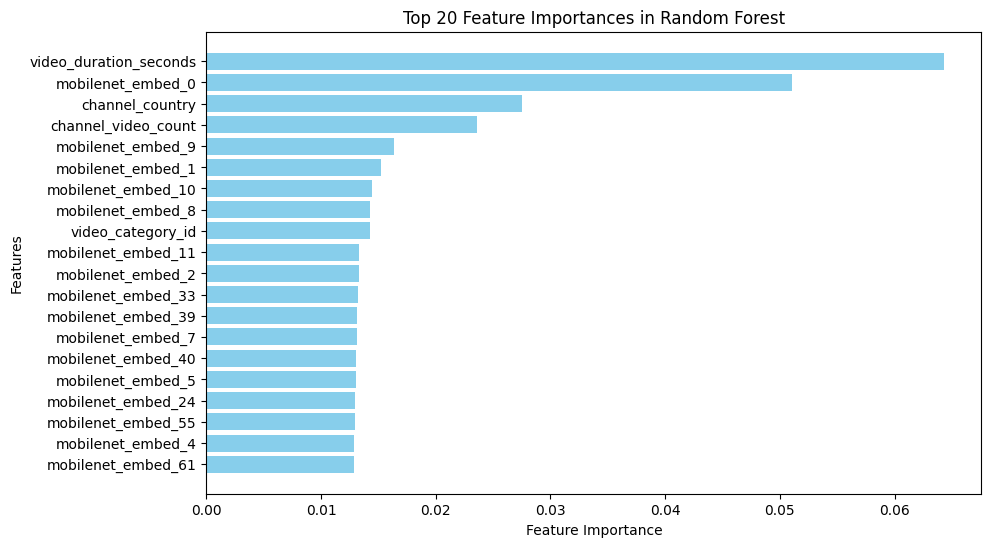

In [97]:
combined_features = combined_features.sort_values(by='Importance', ascending=False).head(20)

plt.figure(figsize=(10, 6))
plt.barh(combined_features['Feature'], combined_features['Importance'], color='skyblue')
plt.xlabel('Feature Importance')
plt.ylabel('Features')
plt.title('Top 20 Feature Importances in Random Forest')
plt.gca().invert_yaxis()
plt.show()

In [ ]:
# from transformers import pipeline

# text_features = ['video_title']

# def clean_text_column(column):

#     return (
#         column.fillna("") 
#         .str.replace(r"[^\w\s]", " ", regex=True) 
#         .str.lower()  
#         .str.strip()  
#     )

# for text_feature in text_features:
#     data[text_feature] = clean_text_column(data[text_feature])
    
    
# from transformers import pipeline
# import torch
# import seaborn as sns
# import matplotlib.pyplot as plt

# device = 0 if torch.cuda.is_available() else -1

# emotion_analyzer = pipeline("text-classification", model="j-hartmann/emotion-english-distilroberta-base", device=device)

# data['video_title_emotion'] = data['video_title'].apply(lambda x: emotion_analyzer(x)[0]['label'])

# # Plot emotion distribution
# plt.figure(figsize=(10, 6))
# sns.countplot(y=data['video_title_emotion'], order=data['video_title_emotion'].value_counts().index)
# plt.title('Emotion Distribution in Video Titles')
# plt.xlabel('Count')
# plt.ylabel('Emotion')
# plt.tight_layout()
# plt.show()

In [ ]:
# emotion_analysis = data.groupby('video_title_emotion').agg({
#     'engagement_rate': 'mean',
#     'is_trending': 'mean'
# }).reset_index()

# emotion_analysis.rename(columns={
#     'engagement_rate': 'avg_engagement_rate',
#     'is_trending': 'proportion_trending'
# }, inplace=True)

# plt.figure(figsize=(10, 6))
# sns.barplot(x='avg_engagement_rate', y='video_title_emotion', data=emotion_analysis)
# plt.title('Average Engagement Rate by Emotion')
# plt.xlabel('Average Engagement Rate')
# plt.ylabel('Emotion')
# plt.tight_layout()
# plt.show()

# plt.figure(figsize=(10, 6))
# sns.barplot(x='proportion_trending', y='video_title_emotion', data=emotion_analysis)
# plt.title('Proportion of Videos Trending by Emotion')
# plt.xlabel('Proportion Trending')
# plt.ylabel('Emotion')
# plt.tight_layout()
# plt.show()